In [258]:
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.image as img
import seaborn as sns
matplotlib.rcParams.update({'font.size':10})

In [253]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [254]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [122]:
# загрузка данных
DATASET_PATH_TRAIN ='Desktop/DS продолжение/Курсовая/course_project_train.csv'
DATASET_PATH_TEST ='Desktop/DS продолжение/Курсовая/course_project_test.csv'

# сохранение данных
DATASET_PATH_TEST_PRED = 'Desktop/DS продолжение/Курсовая/pred_test.csv' 

In [123]:
train_df = pd.read_csv(DATASET_PATH_TRAIN) # загружаем тренировочный датасет
test_df = pd.read_csv(DATASET_PATH_TEST) # и тестовый

full_df = pd.concat([train_df,test_df],ignore_index=True) # объединяем датасеты для дальнейшего преобразования данных(заполнение пропусков, корректировка выбросов)

full_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [41]:
full_df.shape # проверяем, что данные объединились

(10000, 17)

In [188]:
full_df.isnull().sum() # проверяем на наличиее пропусков в данных

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                  2500
Home_Ownership_flg                 0
Years_in_current_job_cnt           0
Cnt_ Purpose                       0
Term_bin                           0
Problem_rating                     0
Solvency                           0
Cnt_credit_problem                 0
Solvency_bin                       0
dtype: int64

In [43]:
full_df.describe() # а так же на выбросы

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,4561.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,34.564569,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,21.771990,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,16.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,0.000000,10.00000,17.000000,4.781810e+05,0.00000,32.000000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,50.000000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*	Home Ownership  	-	Домовладение
*	Annual Income  	-	Годовой доход
*	Years in current job	-	Годы на текущей работе
*	Tax Liens  	-	Налоговые залоги
*	Number of Open Accounts	-	Количество открытых счетов
*	Years of Credit History	-	Годы кредитной истории
*	Maximum Open Credit 	-	Максимальный открытый кредит
*	Number of Credit Problems	-	Количество проблем с кредитованием
*	Months since last delinquent	-	Месяцев с последнего просрочки
*	Bankruptcies   	-	Банкротства
*	Purpose   	-	Цель
*	Term   	-	Срок
*	Current Loan Amount 	-	Текущая сумма кредита
*	Current Credit Balance 	-	Текущий кредитный баланс
*	Monthly Debt  	-	Ежемесячный долг
*	Credit Score  	-	Кредитный рейтинг
*	Credit Default  	-	Кредитный дефолт


> В данном датасете наличие пустых строк и выбросов не является ошибкой, а наоборот. Поскольку наличие пустых строк, к примеру, в Months since last delinquent говорит о том, что клиентплатит кредит без просрочек.
То же самое и с выбросами.

In [72]:
full_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                  float64
Home_Ownership_flg              float64
Years_in_current_job_cnt          int64
Cnt_ Purpose                      int64
Term_bin                          int64
Problem_rating                  float64
Solvency                        float64
Cnt_credit_problem              float64
dtype: object

In [45]:
full_df.select_dtypes(include='object') # посмотрим какие признаки имеют тип object

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
...,...,...,...,...
9995,Home Mortgage,10+ years,debt consolidation,Short Term
9996,Home Mortgage,2 years,debt consolidation,Short Term
9997,Home Mortgage,2 years,debt consolidation,Short Term
9998,Rent,10+ years,debt consolidation,Short Term


In [46]:
full_df['Home Ownership'].value_counts() # Посмотри признаки столбца 'Home Ownership'

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

In [124]:
#видим, что есть два признака Home Mortgage и Have Mortgage, которые по своему смыслу идентичны. 
# Поэтому Have Mortgage преобразуем в Home Mortgage 

full_df.loc[full_df['Home Ownership']== "Have Mortgage",'Home Ownership'] = "Home Mortgage"

In [125]:
# далее преобразуем признак Home Ownership в числовое значение, а именно 0.5= Home Mortgage, 0 = Rent, 1 = Own Home
full_df['Home_Ownership_flg'] = full_df['Home Ownership'].replace({'Rent':0, 'Own Home':1,'Home Mortgage':0.5})
full_df['Home_Ownership_flg'].value_counts()

0.5    4881
0.0    4224
1.0     895
Name: Home_Ownership_flg, dtype: int64

In [49]:
full_df['Years in current job'].value_counts() # Посмотри признаки столбца Years in current job

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

В столбце 'Years in current job' присутствует признак '<1 years'. Можно тех, у кого этот признак пустой, заменить на '<1 years', 
т.к. кредит обычно выдается с стажем минимум 3 месяца.

И преобразуем строковые значения в числовые соответственно. '<1 years' прировняем к нулю

In [126]:
full_df.loc[full_df['Years in current job'].isnull(),'Years in current job'] = "< 1 year"
full_df['Years_in_current_job_cnt'] = full_df['Years in current job'].replace({'10+ years':10,
                                                                               '< 1 year':0,
                                                                               '2 years':2,
                                                                               '3 years':3,
                                                                               '5 years':5,
                                                                               '1 year': 1,
                                                                               '4 years':4,
                                                                               '6 years':6,
                                                                               '7 years':7,
                                                                               '8 years':8,
                                                                               '9 years':9})

In [51]:
full_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home_Ownership_flg,Years_in_current_job_cnt
0,Own Home,482087.0,< 1 year,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0,1.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0,1.0,10
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0,0.5,8
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0,1.0,6
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0,0.0,8


In [52]:
full_df['Purpose'].value_counts() # теперь посчитаем количество значений из столбца Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64

In [127]:
# И заджоиним к основной таблице эти значение по столбцу Purpose, чтобы получить числовые значения
cnt_purpose = full_df['Purpose'].value_counts().reset_index()\
    .rename(columns={'index':'Purpose','Purpose':'Cnt_ Purpose'})
full_df = full_df.merge(cnt_purpose, on='Purpose', how='left')
full_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home_Ownership_flg,Years_in_current_job_cnt,Cnt_ Purpose
0,Own Home,482087.0,< 1 year,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0,1.0,0,7917
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0,1.0,10,7917
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0,0.5,8,7917
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0,1.0,6,7917
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0,0.0,8,7917


> Проделаем ту же самую процедуру для столбца Term, только через бинарные значения

In [128]:
full_df['Term_bin'] = full_df['Term'].replace({'Short Term':0, 'Long Term':1})
full_df['Term_bin'].value_counts()

0    7417
1    2583
Name: Term_bin, dtype: int64

In [129]:
# столбец 'Bankruptcies' отвечает за банкротсва. Поэтому, логично пустые значения заменить на 0
full_df.loc[full_df['Bankruptcies'].isnull(),'Bankruptcies']=0

> Прежде чем заполнять пустоты в столбце Credit Score, необходимо посмотреть зависимость показатель Credit Default от остальных показателей

In [130]:
#добавим столбец, в котором будут саккумулированны все проблемы клиента
full_df['Problem_rating'] = full_df['Number of Credit Problems']+\
full_df['Months since last delinquent'].fillna(0)+\
full_df['Bankruptcies']

In [131]:
#т.к. по некоторым клиентам доход неизвестен,то преравняем пустые значения в столбце Annual Income к 0
full_df.loc[full_df['Annual Income'].isnull(),'Annual Income'] = 0

> необходимо так же рассчитывать платежоспосбность клиента, разделив ежемесячный доход на ежемесячный платеж. (годовой доход делим на 12)
> Так же к этому коэффициенту добавим коэфф. владения домом. 
> Итоговый коэф. для владельцев собственных домов будет выше, чем для арендаторов или ипотечных.

In [132]:
full_df['Solvency'] = full_df['Annual Income']/12/full_df['Monthly Debt'] + full_df['Home_Ownership_flg']
full_df.loc[full_df['Solvency'].isnull(),'Solvency'] = 0

> но в этом рассчете у нас появляются бесконечно большие цифры, которые позже не позволят нам стандартизировать данные. Все остальные значения получились меньше 1500, поэтому бесконечно большшие прироврняем к 2000

In [154]:
full_df.loc[full_df['Solvency']>1500,'Solvency']=2000

получились очень много различных значений, которые сгруппируем по принципу, если коэффициент меньше 2(то есть клиенту хватает оплатить кредит и небольшие дополнительные затраты или ему даже не хватает оплатить кредит - тогда это 0, иначе 1)

In [186]:
full_df.loc[full_df['Solvency']>2,'Solvency_bin'] = 1
full_df.loc[full_df['Solvency']<2,'Solvency_bin'] = 0

проделаем аналогичную операцию с признаком Current Loan Amount, но разделим уже на две группы: меньше 200000 и больше либо равно 200000

In [201]:
full_df.loc[full_df['Current Loan Amount']>=200000,'Current Loan Amount_bin'] = 1
full_df.loc[full_df['Current Loan Amount']<200000,'Current Loan Amount_bin'] = 0

и для столбца Annual Income:меньше 200000(0) и больше либо равно 200000(1) 

In [210]:
full_df.loc[full_df['Annual Income']>=200000,'Annual Income_bin'] = 1
full_df.loc[full_df['Annual Income']<200000,'Annual Income_bin'] = 0

In [133]:
#рассчитаем коэф., отвечающий за кол-во проблем с кредитованием за все время кредитования
full_df['Cnt_credit_problem']=full_df['Number of Credit Problems']/full_df['Years of Credit History'] 

In [134]:
#и пустые значения 'Months since last delinquent' так же приравняем к нулю
full_df.loc[full_df['Months since last delinquent'].isnull(),'Months since last delinquent'] = 0

In [135]:
full_df.loc[(full_df['Credit Default']==1)|(full_df['Credit Default']==0), base_feat + new_feat].isnull().sum()

Annual Income                      0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Years_in_current_job_cnt           0
Cnt_ Purpose                       0
Problem_rating                     0
Solvency                           0
Cnt_credit_problem                 0
dtype: int64

> если внимательно изучить столбец Credit Score, то можно увидеть, что все большие значения начинаются сразу после 800, и имеют первую цифру либо 6, либо 7

In [136]:
full_df.loc[full_df['Credit Score']>800,'Credit Score']

69      6470.0
87      7440.0
94      7010.0
96      7320.0
116     7390.0
         ...  
9949    7300.0
9970    6470.0
9972    7410.0
9977    7480.0
9999    6820.0
Name: Credit Score, Length: 560, dtype: float64

> Это значит, что скорее всего при загрузке данных произошла ошибка и некоторые значения увеличили в 10. Поэтому разделим все значения Credit Score > 800 на 10

In [137]:
full_df.loc[full_df['Credit Score']>800,'Credit Score']=full_df.loc[full_df['Credit Score']>800,'Credit Score']/10

> у нас еще остаются пустые значения в столбце 'Credit Score'. Заполним медианными значениями

In [138]:
full_df.loc[full_df['Credit Score'].isnull(),'Credit Score']=full_df['Credit Score'].median()

In [113]:
full_df.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                  2500
Home_Ownership_flg                 0
Years_in_current_job_cnt           0
Cnt_ Purpose                       0
Term_bin                           0
Problem_rating                     0
Solvency                           0
Cnt_credit_problem                 0
dtype: int64

теперь стандартизируем все полученые значения посредством StandartScaller

In [156]:
std = StandardScaler()

base_feat = [                   
'Annual Income',                             
'Tax Liens',                         
'Number of Open Accounts',           
'Years of Credit History',            
'Maximum Open Credit',               
'Number of Credit Problems',         
'Months since last delinquent',                                                                               
'Current Loan Amount',             
'Current Credit Balance',         
'Monthly Debt',                
'Credit Score']

new_feat = [             
'Years_in_current_job_cnt',         
'Cnt_ Purpose',                                          
'Problem_rating',                 
'Solvency',                         
'Cnt_credit_problem']

target = 'Credit Default'

In [157]:
stand_feat = std.fit_transform(full_df[base_feat + new_feat].fillna(0))
stand_feat.mean(axis=0), stand_feat.std(axis=0)

(array([ 8.17124146e-17,  2.55795385e-17,  1.08002496e-16,  2.21866969e-16,
        -2.84217094e-18,  2.84217094e-18, -1.84741111e-17,  3.90798505e-18,
        -4.36983782e-17,  1.07824860e-16, -1.47934998e-15, -1.84741111e-17,
        -1.43884904e-17,  4.40536496e-17,  1.17239551e-17,  3.30402372e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [187]:
full_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Credit Score,Credit Default,Home_Ownership_flg,Years_in_current_job_cnt,Cnt_ Purpose,Term_bin,Problem_rating,Solvency,Cnt_credit_problem,Solvency_bin
count,1.000000e+04,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,...,10000.00000,7500.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.083654e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,15.764900,0.114400,1.194381e+07,2.914741e+05,...,721.61670,0.281733,0.333550,5.628400,6386.390200,0.258300,16.04730,8.700890,0.009505,0.793000
std,9.477785e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,22.640209,0.349464,3.200878e+07,3.339979e+05,...,25.05644,0.449874,0.316669,3.748562,2988.225344,0.437722,22.72288,42.159199,0.030542,0.405176
min,0.000000e+00,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,...,585.00000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,5.321425e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,0.000000,0.000000,1.805485e+05,1.132258e+05,...,715.00000,0.000000,0.000000,2.000000,7917.000000,0.000000,0.00000,3.558687,0.000000,1.000000
50%,9.910305e+05,0.000000,10.00000,17.000000,4.781810e+05,0.00000,0.000000,0.000000,3.117180e+05,2.090190e+05,...,728.00000,0.000000,0.500000,6.000000,7917.000000,0.000000,2.00000,5.434775,0.000000,1.000000
75%,1.498297e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,29.000000,0.000000,5.210700e+05,3.619500e+05,...,738.00000,1.000000,0.500000,10.000000,7917.000000,1.000000,29.00000,8.192045,0.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,...,751.00000,1.000000,1.000000,10.000000,7917.000000,1.000000,118.00000,2000.000000,0.746269,1.000000


> проведем корреляцию целевого признака от остальных числовых.

In [211]:
base_feat = [  'Annual Income',
'Tax Liens',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
'Months since last delinquent',
'Bankruptcies',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt',
'Credit Score']

new_feat = [             
'Home_Ownership_flg',
'Years_in_current_job_cnt',
'Cnt_ Purpose',
'Term_bin',
'Problem_rating',
'Solvency',
'Solvency_bin',
'Cnt_credit_problem',
'Current Loan Amount_bin',
'Annual Income_bin']

target = 'Credit Default'

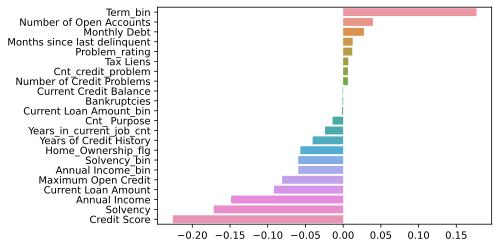

In [212]:
scores = {}
for feat in base_feat+new_feat:
    scores[feat]=2*roc_auc_score(
        y_true=full_df.loc[full_df[target].notnull(),target],y_score=full_df.loc[full_df[target].notnull(),feat],multi_class='ovo')-1
scores = pd.Series(scores).sort_values(ascending=False)
sns.barplot(x=scores.values,y=scores.index)
plt.show()

In [ ]:
На графике видно, что столбец Solvency имеет большую значимость, чем Solvency_bin из-за своей детальности

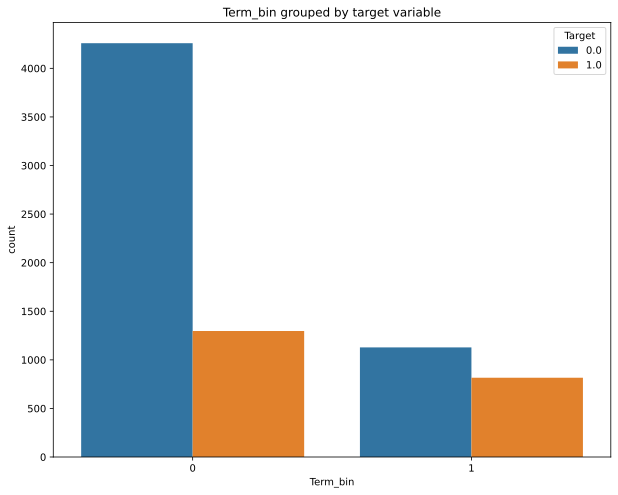

In [205]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Term_bin", hue=target, data=full_df)
plt.title('Term_bin grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Изучив график, можно заметить что для значения 1 (длительный срок кредита) количество дефолта ниже, чем для коротких. Но при этом, количество клиентов без дефолта больше в короткосрочных кредитах(значение 0) 
Но в соотношении внутри признака Term-bin, количество краткосрочных дефолтных кредитов ниже(около 20%), чем в долгосрочном (около 80%). Данный признак важен. Изучим другие

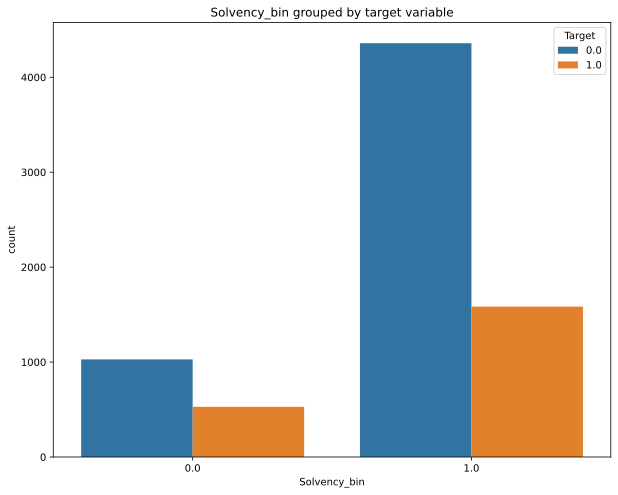

In [206]:
plt.figure(figsize=(10, 8))

sns.countplot(x='Solvency_bin', hue=target, data=full_df)
plt.title('Solvency_bin grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

По аналогии с предыдщим графиком, только наоборот, видим что в более платежеспособном населии (значение 1) дефолта больше по количеству. Но в соотношении, в менее платежоспособном населии дефолт чаще возникает, чем в платжеспособном (около 50%). Данный признак важен, а именно оригинальный (Solvency).
Поэтому сделаем еще одно разбиение, но уже по признаку Solvency

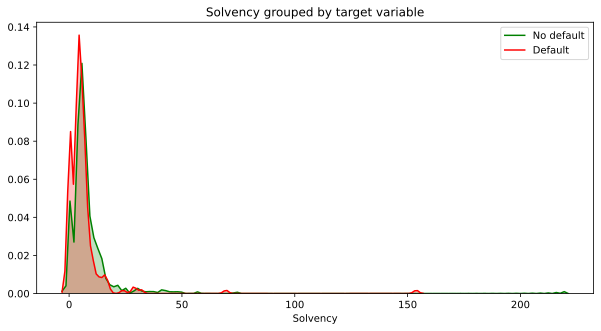

In [238]:
limit_bal_with_target_s = full_df[['Solvency', target]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Solvency']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Solvency')
plt.title('Solvency grouped by target variable')
plt.show()

Наблюдение

>Похоже что две группы, полученные в результате разбиения признака "LIMIT_BAL" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "LIMIT_BAL" и целевой переменной, возможно, существует некоторая функциональная зависимость.

Гипотеза

* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости  α : 0.05
* Критическая область: двухсторонняя

>Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений. Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка

In [243]:
shapiro(limit_bal_s)

ShapiroResult(statistic=0.22886401414871216, pvalue=0.0)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график

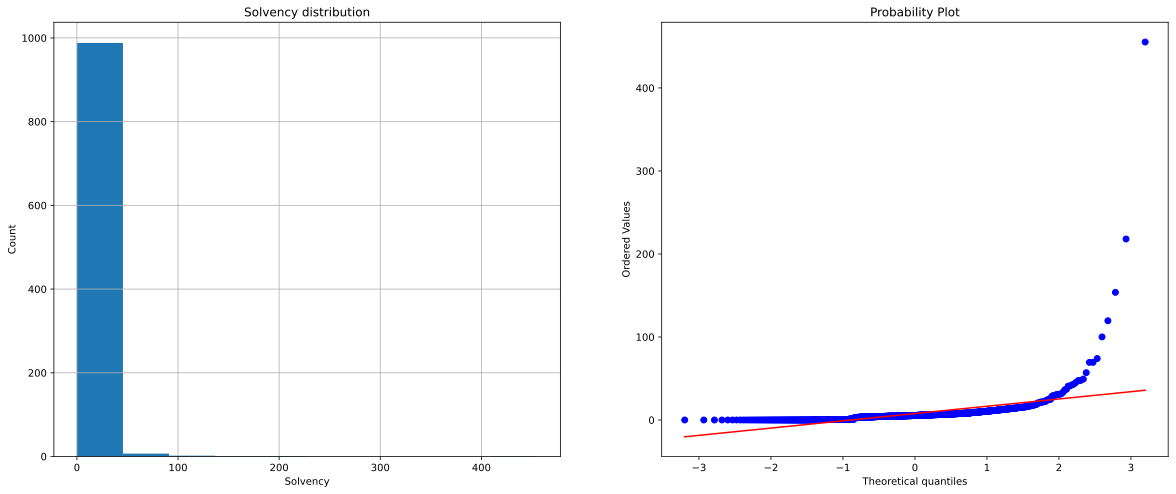

In [246]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Solvency')
ax1.set_ylabel('Count')
ax1.set_title('Solvency distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака LIMIT_BAL в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [247]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=44237.0, pvalue=7.50720881320274e-06)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

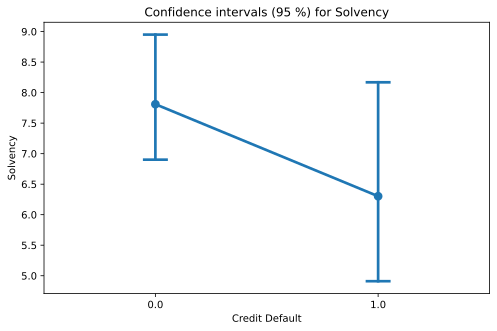

In [248]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=target, y='Solvency', data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Solvency')
plt.show()

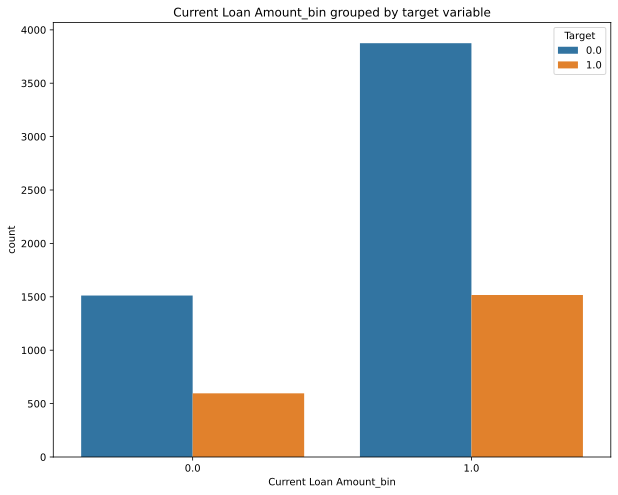

In [207]:
plt.figure(figsize=(10, 8))

sns.countplot(x='Current Loan Amount_bin', hue= target, data=full_df)
plt.title('Current Loan Amount_bin grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

По данному признаку соотношение примерно одинаково(около 30%), поэтому буем брать оригинальный столбец.

И рассмотрим еще один признак из самых значительных 'Annual Income'. Возьмем его бинарную часть

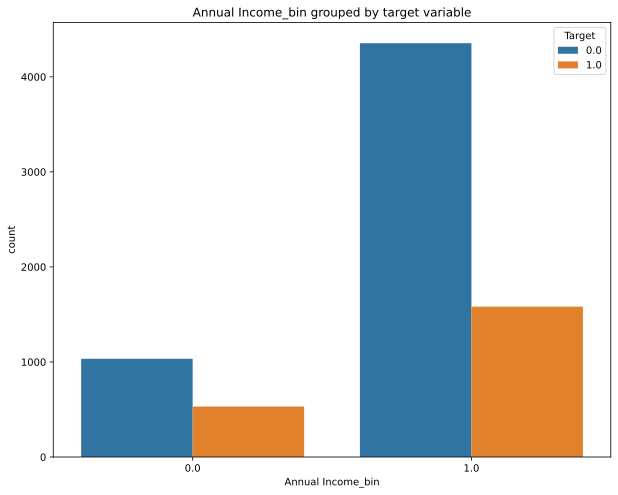

In [213]:
plt.figure(figsize=(10, 8))

sns.countplot(x='Annual Income_bin', hue= target, data=full_df)
plt.title('Annual Income_bin grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Из этого графика видно, что клиенты с доходом менее 200000(0) чаще уходят в дефолт(около 50%). Этот признак тоже оставляем для нашего обучения

In [305]:
base_feat = [  'Annual Income',
'Maximum Open Credit',
'Months since last delinquent',
'Bankruptcies',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt',
'Credit Score']

new_feat = [             
'Home_Ownership_flg',
'Years_in_current_job_cnt',
'Cnt_ Purpose',
'Term_bin',
'Problem_rating',
'Solvency',
'Solvency_bin',
'Cnt_credit_problem',
'Current Loan Amount_bin',
'Annual Income_bin']

target = 'Credit Default'

In [306]:
X = full_df.loc[full_df[target].notnull(),base_feat+new_feat]
y = full_df.loc[full_df[target].notnull(),target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [307]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0.0    4047
1.0    3156
Name: Credit Default, dtype: int64

In [308]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [309]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.61      0.76      0.68      4047
         1.0       0.55      0.37      0.44      3156

    accuracy                           0.59      7203
   macro avg       0.58      0.57      0.56      7203
weighted avg       0.58      0.59      0.57      7203

TEST

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      1340
         1.0       0.42      0.41      0.41       535

    accuracy                           0.67      1875
   macro avg       0.59      0.59      0.59      1875
weighted avg       0.67      0.67      0.67      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1035  305
1.0              317  218


In [264]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      4047
         1.0       0.74      0.71      0.73      3156

    accuracy                           0.76      7203
   macro avg       0.76      0.76      0.76      7203
weighted avg       0.76      0.76      0.76      7203

TEST

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72      1340
         1.0       0.35      0.40      0.37       535

    accuracy                           0.61      1875
   macro avg       0.55      0.55      0.55      1875
weighted avg       0.63      0.61      0.62      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0.0             935  405
1.0             320  215
